In [207]:
import numpy as np
import matplotlib.pyplot as plt

from utils.file_manager import load_scan, windowing_image

dcm_file = "D:/2차년도/골이식재양/한림대/2차년도 상악 54개/2-202 #26/2-202 #26 전CT 20.06.20"

_type, original_data, properties = load_scan(dcm_file)

tr_data = np.transpose(original_data, (2,1,0))
top = tr_data.shape[0]
if _type == 1:
    new_data = tr_data[top-240:top-140]
elif _type == 2:
    new_data = tr_data[top-200:top-100]
elif _type == 4:
    new_data = tr_data[top-160:top-60]
    

4 Tiles Stitching Data...


- 1 Tile = top-240 : top-140
- 2 Tiles Stitching = top-200 : top-100
- 4 Tiles Stitching = top-160 : top-60

In [208]:
# tmp_data = np.transpose(original_data, (1,2,0))
# plt.imshow(tmp_data[150],'gray')
# plt.axhline(top-160, 0, 1, color='red', linestyle='--', linewidth=2)
# plt.axhline(top-60, 0, 1, color='red', linestyle='--', linewidth=2)

In [209]:
print(f"Window Center: {properties['window_center']}")
print(f"Window Width: {properties['window_width']}")

Window Center: 1024
Window Width: 4095


In [210]:
# Perform MIP along specified axis
mip_image = np.max(new_data, axis=0)

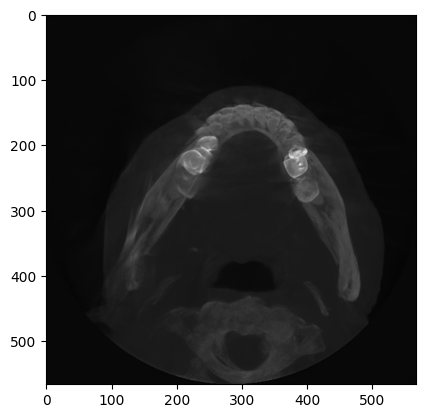

In [211]:
plt.imshow(mip_image, 'gray')

### Windowing and Normalize
---

In [212]:
window_image = windowing_image(mip_image, properties, use_normalize=True)
bone_image = windowing_image(mip_image, properties,window=(400,1800), use_normalize=True)

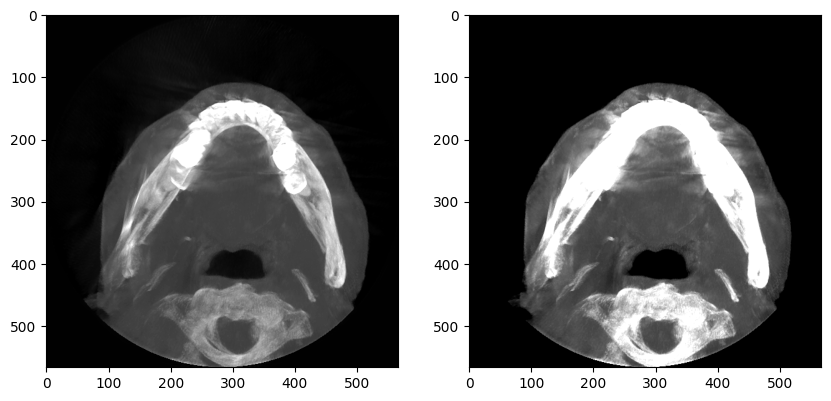

In [213]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(window_image, 'gray')
ax[1].imshow(bone_image, 'gray')

### Apply gamma
---

In [214]:
def gamma_correction(image, gamma, c=1.0):
    """
    감마 변환을 수행하는 함수
    
    Parameters:
    -----------
    image : numpy.ndarray
        입력 이미지 (0-255 범위의 uint8 또는 0-1 범위의 float)
    gamma : float
        감마 값 (γ)
        γ > 1: 어두운 영역 압축 (밝은 부분 강조)
        γ < 1: 밝은 영역 압축 (어두운 부분 강조)
    c : float, optional
        스케일링 팩터 (기본값: 1.0)
    
    Returns:
    --------
    numpy.ndarray
        감마 변환이 적용된 이미지
    """
    # 입력 이미지를 0-1 범위로 정규화
    if image.dtype == np.uint8:
        image = image / 255.0
        
    # 감마 변환 수행: s = c * r^γ
    corrected = c * np.power(image, gamma)
    
    # 값의 범위를 0-1로 클리핑
    corrected = np.clip(corrected, 0, 1)
    
    # 원본이 uint8이었다면 다시 0-255로 변환
    if image.dtype == np.uint8:
        corrected = (corrected * 255).astype(np.uint8)
        
    return np.array(corrected)

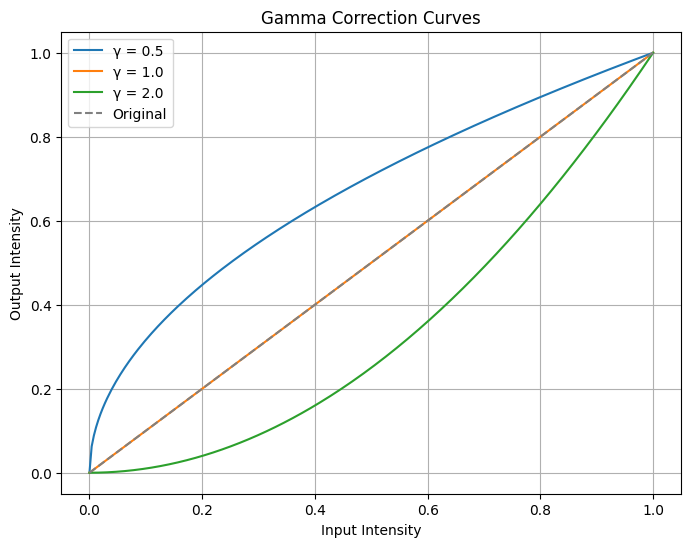

In [215]:
def plot_gamma_curves(gammas=[0.5, 1.0, 2.0]):
    """
    감마 변환 곡선을 시각화하는 함수
    """
    x = np.linspace(0, 1, 256)
    
    plt.figure(figsize=(8, 6))
    for gamma in gammas:
        y = gamma_correction(x, gamma)
        plt.plot(x, y, label=f'γ = {gamma}')
    
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Original')
    plt.xlabel('Input Intensity')
    plt.ylabel('Output Intensity')
    plt.title('Gamma Correction Curves')
    plt.legend()
    plt.grid(True)
    plt.show()
# 감마 변환 곡선 시각화
plot_gamma_curves()


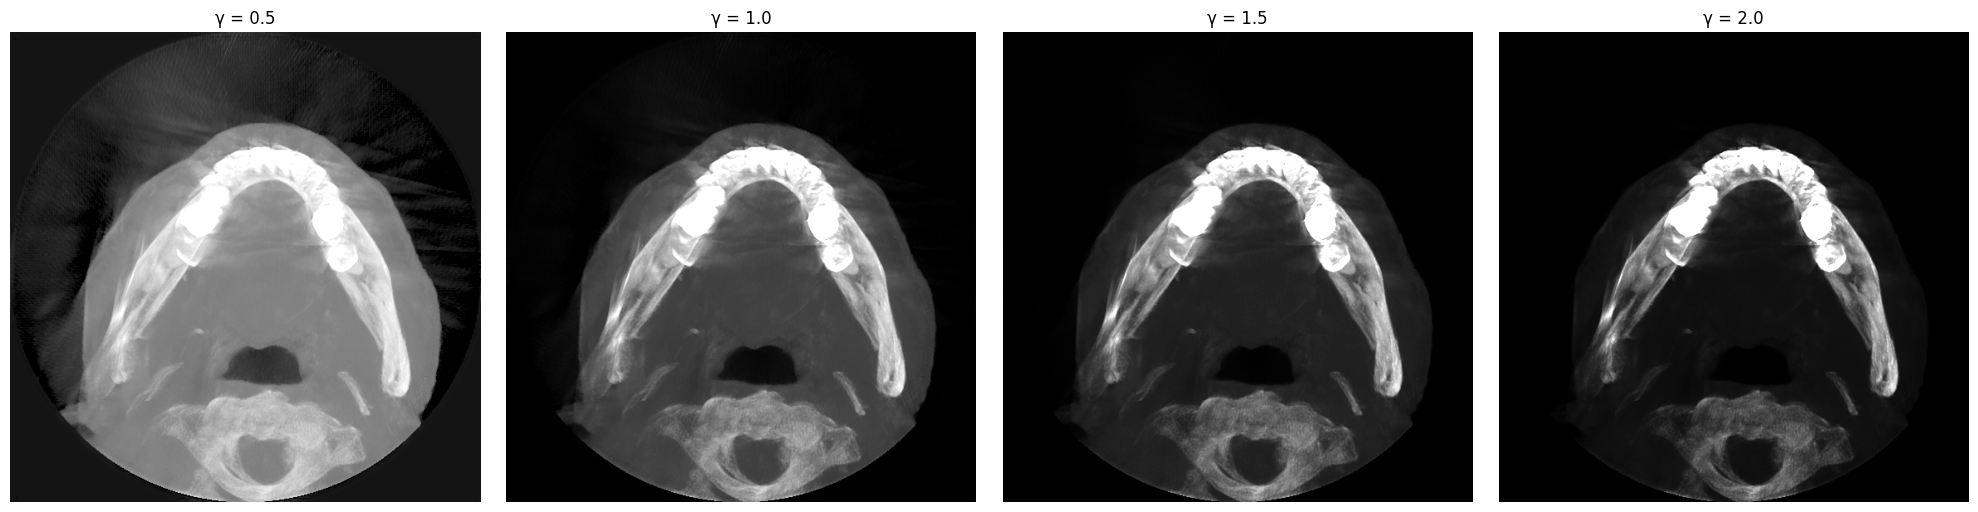

In [216]:
def visualize_gamma_effect(image, gammas=[0.5, 1.0, 1.5, 2.0]):
    """
    다양한 감마 값의 효과를 시각화하는 함수
    
    Parameters:
    -----------
    image : numpy.ndarray
        입력 이미지
    gammas : list of float
        테스트할 감마 값들의 리스트
    """
    fig, axes = plt.subplots(1, len(gammas), figsize=(5*len(gammas), 5))
    
    for ax, gamma in zip(axes, gammas):
        corrected = gamma_correction(image, gamma)
        ax.imshow(corrected, cmap='gray')
        ax.set_title(f'γ = {gamma}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
# 다양한 감마 값의 효과 시각화
visualize_gamma_effect(window_image)


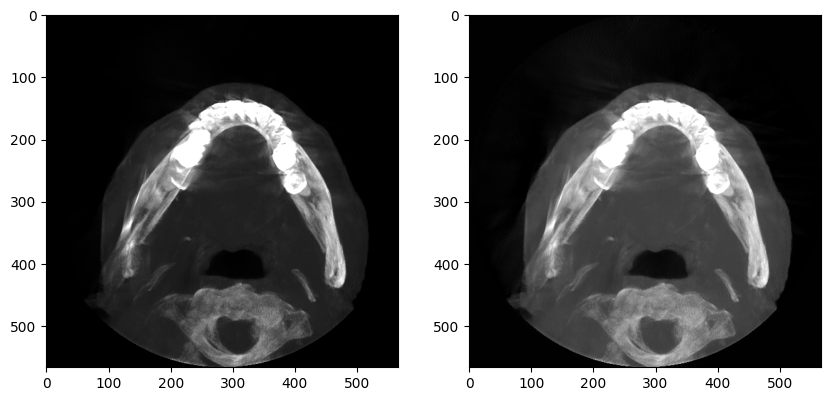

In [217]:
test_image = gamma_correction(window_image, gamma=1.5)
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(test_image,'gray')
ax[1].imshow(window_image, 'gray')

## Binarization
---

In [218]:
import numpy as np
from scipy import ndimage
from skimage import filters
import matplotlib.pyplot as plt

def region_growing_binary(image, seed_points=None, threshold=0.1):
    """
    Region growing 방식의 이진화
    
    Parameters:
    -----------
    image : numpy.ndarray
        입력 이미지
    seed_points : list of tuple
        시작점 좌표 [(y1,x1), (y2,x2), ...]
    threshold : float
        성장 기준 임계값
        
    Returns:
    --------
    numpy.ndarray
        이진화된 이미지
    """
    if seed_points is None:
        # 이미지 중심을 시작점으로 사용
        center_y, center_x = [dim//2 for dim in image.shape]
        seed_points = [(center_y, center_x)]
    
    # 방문 마스크 초기화
    mask = np.zeros_like(image, dtype=np.uint8)
    
    # 시작점의 값을 기준으로 설정
    for seed_y, seed_x in seed_points:
        reference = image[seed_y, seed_x]
        stack = [(seed_y, seed_x)]
        
        while stack:
            y, x = stack.pop()
            if not mask[y, x]:
                # 현재 픽셀 방문 표시
                mask[y, x] = 1
                
                # 4방향 이웃 픽셀 확인
                for dy, dx in [(-1,0), (1,0), (0,-1), (0,1)]:
                    new_y, new_x = y + dy, x + dx
                    
                    # 이미지 범위 체크
                    if (0 <= new_y < image.shape[0] and 
                        0 <= new_x < image.shape[1] and 
                        not mask[new_y, new_x]):
                        # 임계값 이내의 차이를 보이는 픽셀 추가
                        if abs(image[new_y, new_x] - reference) < threshold:
                            stack.append((new_y, new_x))
    
    return mask.astype(np.uint8)

def post_process_binary(binary_img, min_size=100):
    """
    이진화 이미지의 후처리
    
    Parameters:
    -----------
    binary_img : numpy.ndarray
        이진화된 이미지
    min_size : int
        최소 객체 크기
        
    Returns:
    --------
    numpy.ndarray
        후처리된 이진화 이미지
    """
    # 작은 객체 제거
    cleaned = ndimage.binary_opening(binary_img, structure=np.ones((3,3)))
    
    # 레이블링
    labeled, num_features = ndimage.label(cleaned)
    
    # 크기가 작은 객체 제거
    for i in range(1, num_features + 1):
        if np.sum(labeled == i) < min_size:
            cleaned[labeled == i] = 0
            
    return cleaned.astype(np.uint8)

def invert_binary_image(image):
    """
    이진 이미지(0과 1로 구성된 2차원 리스트)의 값을 반전시킵니다.
    
    Args:
        image: 2차원 리스트 형태의 이진 이미지
        
    Returns:
        inverted_image: 반전된 이진 이미지
    """
        
    rows = len(image)
    cols = len(image[0])
    
    # 새로운 이미지 생성
    inverted = [[0 for _ in range(cols)] for _ in range(rows)]
    
    # 각 픽셀 반전
    for i in range(rows):
        for j in range(cols):
            inverted[i][j] = 1 if image[i][j] == 0 else 0
            
    return np.array(inverted)


In [219]:
# from skimage.filters import sobel
# region = sobel(test_image)
# plt.imshow(region, 'gray')

In [220]:
# markers = np.zeros_like(test_image)
# markers[test_image < 0.1] = 0
# markers[test_image >= 0.1] = 1

In [221]:
# plt.imshow(markers, 'gray')

In [222]:
# np.min(markers), np.max(markers), np.unique(markers)

In [223]:
# # from skimage import morphology
# from scipy.ndimage import morphology

# # result = morphology.area_closing(markers)
# result = morphology.binary_closing(markers, iterations=10)

# plt.imshow(result, 'gray')

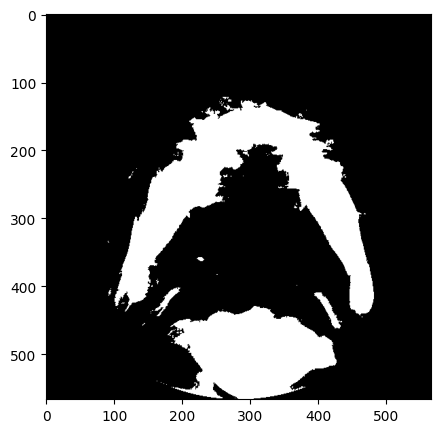

In [224]:
midle_point = (int(test_image.shape[0] / 2), int(test_image.shape[1] / 2))
seed_points = ([(0,0), midle_point])
binary_region = region_growing_binary(test_image, seed_points=seed_points, threshold=0.2)
binary_region = invert_binary_image(binary_region)
# cleaned_binary = ~post_process_binary(binary_region, min_size=100)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(binary_region, 'gray')

In [225]:
# np.min(binary_region), np.max(binary_region), np.unique(binary_region)

### 9 Segmented arch area
---

In [226]:
def find_largest_component(grid):
    """
    2차원 리스트로 표현된 이진 이미지에서 가장 큰 연결된 1의 영역을 찾습니다.
    반복문을 사용하여 재귀 제한을 피합니다.
    
    Args:
        grid: 2차원 리스트 (각 셀은 0 또는 1)
    
    Returns:
        new_grid: 가장 큰 영역만 1로 표시된 2차원 리스트
        max_size: 가장 큰 영역의 크기
    """
    
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    
    def get_component(start_r, start_c):
        """반복문을 사용하여 연결된 모든 1을 찾아 반환"""
        if grid[start_r][start_c] != 1:
            return set()
            
        component = set()
        stack = [(start_r, start_c)]
        
        while stack:
            r, c = stack.pop()
            
            if (r, c) in visited:
                continue
                
            if r < 0 or r >= rows or c < 0 or c >= cols:
                continue
                
            if grid[r][c] != 1:
                continue
                
            visited.add((r, c))
            component.add((r, c))
            
            # 8방향의 이웃을 스택에 추가
            neighbors = [
                (r+1,c), (r-1,c), (r,c+1), (r,c-1),
                (r+1,c+1), (r-1,c-1), (r+1,c-1), (r-1,c+1)
            ]
            
            for nr, nc in neighbors:
                if (nr, nc) not in visited:
                    stack.append((nr, nc))
            
        return component
    
    # 모든 연결 영역 찾기
    all_components = []
    for i in range(rows):
        for j in range(cols):
            if (i, j) not in visited and grid[i][j] == 1:
                component = get_component(i, j)
                if component:
                    all_components.append(component)
    
    # 빈 그리드 처리
    if not all_components:
        return [[0 for _ in range(cols)] for _ in range(rows)], 0
    
    # 가장 큰 영역 찾기
    largest = max(all_components, key=len)
    
    # 결과 그리드 생성
    result = [[0 for _ in range(cols)] for _ in range(rows)]
    for r, c in largest:
        result[r][c] = 1
    
    return result, len(largest)

In [227]:
result, max_len = find_largest_component(binary_region)

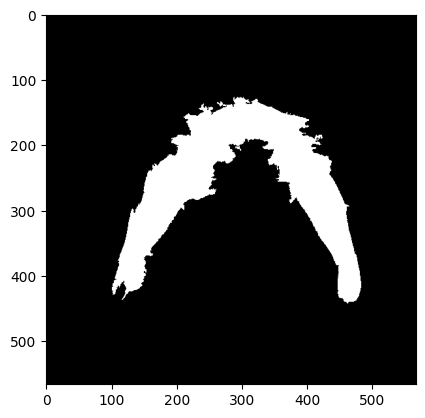

In [228]:
plt.imshow(result, 'gray')

### 10. The arch area after morphological
---

In [229]:
# def fill_holes(image):
#     """
#     이진 이미지에서 구멍을 메웁니다.
#     1로 둘러싸인 0을 1로 변환합니다.
    
#     Args:
#         image: 2차원 리스트 형태의 이진 이미지
        
#     Returns:
#         filled_image: 구멍이 메워진 이진 이미지
#     """
#     if not image or not image[0]:
#         return []
        
#     rows = len(image)
#     cols = len(image[0])
    
#     # 결과 이미지 복사
#     filled = [[image[i][j] for j in range(cols)] for i in range(rows)]
    
#     # 변경이 있었는지 확인하는 플래그
#     changed = True
    
#     # 더 이상 변경이 없을 때까지 반복
#     while changed:
#         changed = False
        
#         for i in range(rows):
#             for j in range(cols):
#                 if filled[i][j] == 0:  # 0인 픽셀에 대해서만 검사
#                     # 상하좌우에 있는 1의 개수 확인
#                     ones_count = 0
#                     neighbors = []
                    
#                     # 상하좌우 이웃 좌표 생성
#                     if i > 0: neighbors.append((i-1, j))      # 상
#                     if i < rows-1: neighbors.append((i+1, j)) # 하
#                     if j > 0: neighbors.append((i, j-1))      # 좌
#                     if j < cols-1: neighbors.append((i, j+1)) # 우
                    
#                     # 이웃한 1의 개수 세기
#                     for ni, nj in neighbors:
#                         if filled[ni][nj] == 1:
#                             ones_count += 1
                    
#                     # 3개 이상의 이웃이 1이면 현재 픽셀을 1로 변경
#                     if ones_count >= 3:
#                         filled[i][j] = 1
#                         changed = True
    
#     return np.array(filled)

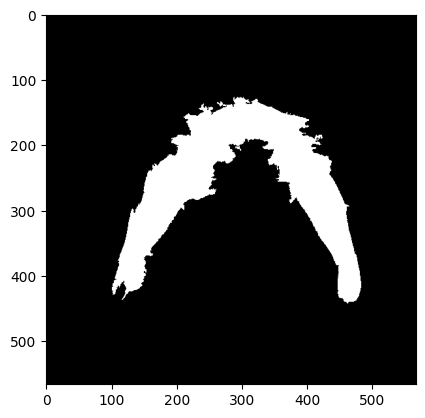

In [230]:
import scipy.ndimage as ndi
result_10 = ndi.binary_fill_holes(result)
# result_10 = fill_holes(result)
plt.imshow(result_10, 'gray')

### 11. Apply Gaussian Filter
---

In [231]:
import numpy as np
from scipy.ndimage import gaussian_filter

def detect_edges(binary_image, edge_width=2):
    """
    이진 이미지에서 가장자리를 감지합니다.
    
    Args:
        binary_image (np.ndarray): 0과 1로 이루어진 2차원 이진 이미지
        edge_width (int): 가장자리로 검출할 픽셀의 너비
    
    Returns:
        np.ndarray: 가장자리 픽셀이 1인 이진 이미지
    """
    # 패딩된 이미지 생성
    padded = np.pad(binary_image, pad_width=edge_width, mode='constant', constant_values=0)
    edges = np.zeros_like(binary_image)
    
    # 각 픽셀의 주변을 확인하여 가장자리 감지
    for i in range(edge_width, padded.shape[0]-edge_width):
        for j in range(edge_width, padded.shape[1]-edge_width):
            if padded[i, j] == 1:
                window = padded[i-edge_width:i+edge_width+1, j-edge_width:j+edge_width+1]
                if not np.all(window == 1):
                    edges[i-edge_width, j-edge_width] = 1
                    
    return edges

def smooth_edges(binary_image, sigma=2.0, edge_width=2, iterations=2):
    """
    이진 이미지의 가장자리를 가우시안 필터로 부드럽게 합니다.
    
    Args:
        binary_image (np.ndarray): 0과 1로 이루어진 2차원 이진 이미지
        sigma (float): 가우시안 필터의 표준편차
        edge_width (int): 가장자리 검출 너비
        iterations (int): 가우시안 필터 적용 반복 횟수
        
    Returns:
        np.ndarray: 가장자리가 부드러워진 이미지
    """
    # 원본 이미지 복사
    smoothed = binary_image.copy().astype(float)
    
    # 가장자리 감지
    edges = detect_edges(binary_image, edge_width)
    
    # 반복적으로 가우시안 필터 적용
    edge_smoothed = edges.astype(float)
    for _ in range(iterations):
        edge_smoothed = gaussian_filter(edge_smoothed, sigma=sigma)
    
    # 원본 이미지에서 가장자리 부분만 부드럽게 처리
    mask = edges == 1
    smoothed[mask] = edge_smoothed[mask]
    
    # 값의 범위를 0~1로 정규화
    if np.max(smoothed) > 1:
        smoothed = smoothed / np.max(smoothed)
    smoothed[smoothed != 1] = 0
    return smoothed

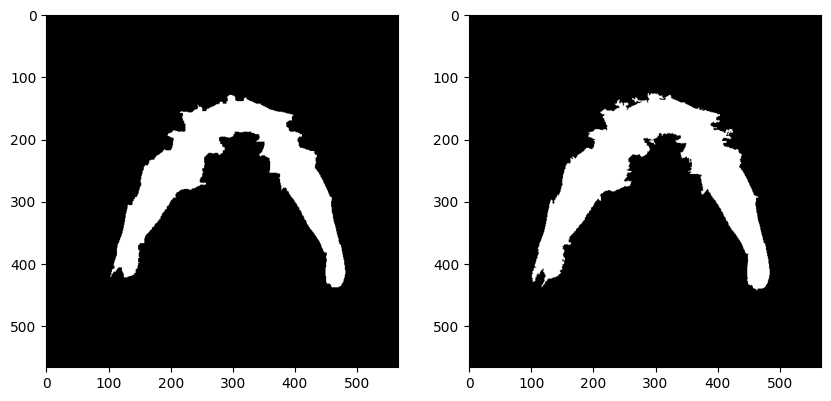

In [239]:
from skimage.filters import gaussian

result_12 = smooth_edges(result_10, sigma=2.0, edge_width=2, iterations=2)
# result_12 = gaussian(result_10, sigma=2.0, mode="wrap")
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(result_12, 'gray')
ax[1].imshow(result_10, 'gray')

### 13. skeletonize
---

In [240]:
from skimage.morphology import skeletonize

def extract_skeleton(image):
    """
    이미지에서 골격을 추출합니다.
    
    Args:
        image: 2D 이미지
    Returns:
        np.ndarray: 골격화된 이미지
    """
    # 골격화 수행
    skeleton = skeletonize(image, method='lee')
    
    return skeleton

In [241]:
skeleton = extract_skeleton(result_12)
skeleton[skeleton == 255] = 1

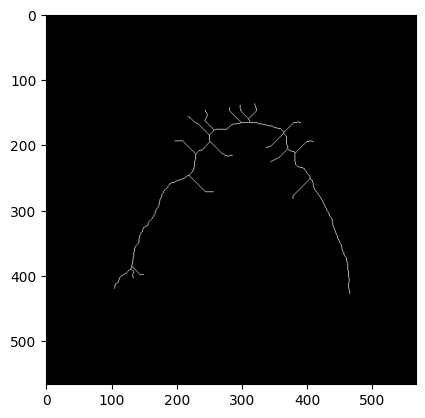

In [242]:
plt.imshow(skeleton, 'gray')

In [243]:
from utils.plot_manager import show_mask
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

def find_longest_path(binary_image):
    """
    미로와 같은 이진 이미지에서 가장 긴 경로를 찾습니다.
    
    Args:
        binary_image (np.ndarray): 0과 1로 이루어진 2차원 이진 이미지
        
    Returns:
        np.ndarray: 가장 긴 경로만 표시된 이진 이미지
    """
    # 이미지의 모든 픽셀 위치를 노드로 변환
    y_indices, x_indices = np.where(binary_image == 1)
    points = list(zip(y_indices, x_indices))
    n_points = len(points)
    
    if n_points == 0:
        return np.zeros_like(binary_image)
    
    # 포인트 인덱스 매핑 생성
    point_to_idx = {point: idx for idx, point in enumerate(points)}
    
    # 인접 행렬 생성
    adjacency_matrix = np.zeros((n_points, n_points))
    
    # 8방향 이웃 검사
    neighbors = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
    
    for i, (y, x) in enumerate(points):
        for dy, dx in neighbors:
            ny, nx = y + dy, x + dx
            neighbor = (ny, nx)
            if neighbor in point_to_idx:
                j = point_to_idx[neighbor]
                adjacency_matrix[i, j] = 1
    
    # 희소 행렬로 변환
    graph = csr_matrix(adjacency_matrix)
    
    # 모든 점 쌍 사이의 최단 거리 계산
    distances = shortest_path(graph)
    
    # 가장 긴 경로의 시작점과 끝점 찾기
    max_distance = 0
    start_idx = end_idx = 0
    
    for i in range(n_points):
        for j in range(i + 1, n_points):
            if distances[i, j] > max_distance and distances[i, j] != np.inf:
                max_distance = distances[i, j]
                start_idx = i
                end_idx = j
    
    # 최장 경로 추적
    result = np.zeros_like(binary_image)
    
    def get_path(start_idx, end_idx):
        """시작점과 끝점 사이의 경로를 찾습니다."""
        current = start_idx
        path = [current]
        while current != end_idx:
            neighbors = np.where(adjacency_matrix[current] > 0)[0]
            next_point = min(neighbors, 
                           key=lambda x: distances[x, end_idx] if distances[x, end_idx] != np.inf else float('inf'))
            path.append(next_point)
            current = next_point
        return path
    
    # 경로를 이미지에 표시
    path_indices = get_path(start_idx, end_idx)
    for idx in path_indices:
        y, x = points[idx]
        result[y, x] = 1
    
    return result

In [244]:
clear = find_longest_path(skeleton)

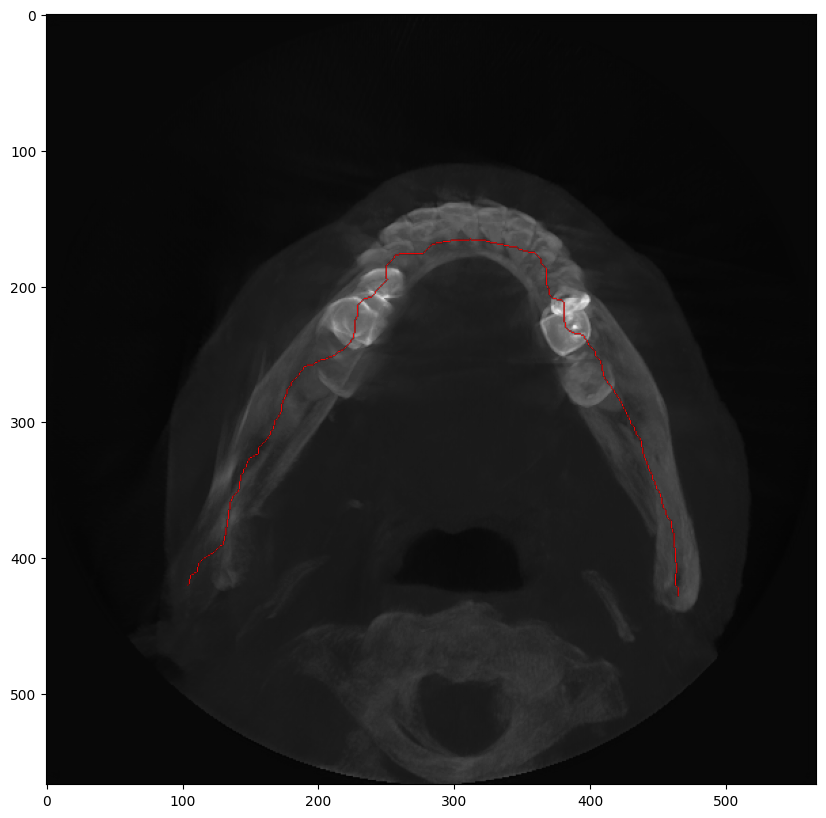

In [245]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(mip_image, 'gray')
show_mask(clear, ax)